In [1]:
import numpy as np
import pandas as pd
import toolz as tz
import itertools as it
import functools as ft

import seaborn as sns

import rospy
from rosh import Bagy

from robot_wardrive.msg import SignalLocation, PingLocation

# Load Data

In [2]:
ls patrolling_2015-06-08/

2015-06-08-10-52_google.bagy  2015-06-08-10-52_signal_location.bagy
2015-06-08-10-52_google.csv   2015-06-08-15-42_google.bagy
2015-06-08-10-52_mpc.bagy     2015-06-08-15-42_mpc.bagy
2015-06-08-10-52_mpc.csv


In [3]:
msgs = None
columns=['secs', 'x', 'y', 'delay']

bagy_name = 'patrolling_2015-06-08/2015-06-08-10-52_google.bagy'
with Bagy(bagy_name, 'r', PingLocation) as bagy:
    msgs = pd.DataFrame([(msg.header.stamp.secs, msg.pose.position.x, msg.pose.position.y, msg.delay) for msg in bagy], columns=columns)
                

In [4]:
# msgs.to_csv('2015-06-08-10-52_google.csv')

In [5]:
#msgs = msgs.ix[1:]

In [6]:
msgs.head()

,secs,x,y,delay
0,1433753551,0.00000,0.000000,2.75
1,1433753552,15.49182,32.360715,2.71
2,1433753552,15.49182,32.360715,3.25
3,1433753553,15.49182,32.360715,2.76
4,1433753553,15.49182,32.360715,2.74


In [7]:
msgs.describe()

,secs,x,y,delay
count,1.157700e+04,11577.000000,11577.000000,11577.000000
mean,1.433757e+09,13.471679,39.618890,5.554994
std,1.829035e+03,1.326617,20.126698,26.842185
min,1.433754e+09,0.000000,0.000000,2.570000
25%,1.433755e+09,12.527996,33.668992,2.710000
50%,1.433757e+09,13.979883,33.668992,2.750000
75%,1.433758e+09,13.979883,33.668992,2.980000
max,1.433760e+09,19.220119,109.003365,1015.000000


# Plots

#Rounding 

In [8]:
rounded = msgs.apply(np.round, decimals=1)

In [9]:
rounded.groupby(['x', 'y']).median().reset_index(inplace=True)

## Plot rounded

In [10]:
# Set image limits
extent=[min(rounded.x - 6.55), max(rounded.x + 5.55),
       min(rounded.y - 4.6),max(rounded.y + 11.4)]

In [132]:
%pylab qt

Populating the interactive namespace from numpy and matplotlib


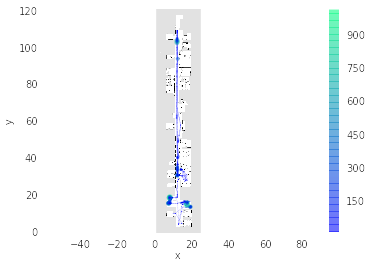

In [220]:
rounded.plot(kind='scatter', x='x', y='y', c='delay',
             s=rounded.delay/25, linewidth=0, alpha=0.5,
             grid=None, cmap="winter")  # cmap=*_r is reversed version of the cmap
img = plt.imread('roboticslab_complete_clean.png')
implot = plt.imshow(img, extent=extent, cmap='Greys_r')
axes().set_aspect('equal', 'datalim')
plt.grid(b=None)
plt.savefig('ping_locations.pdf', grid=None, transparent=False, dpi=300)

# Timestamp vs delay


In [203]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


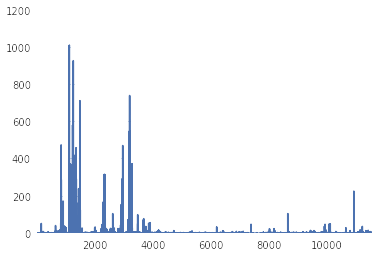

In [219]:
msgs.delay.plot()

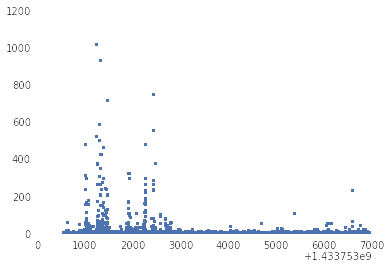

In [218]:
plt.plot(msgs.secs, msgs.delay, '.')

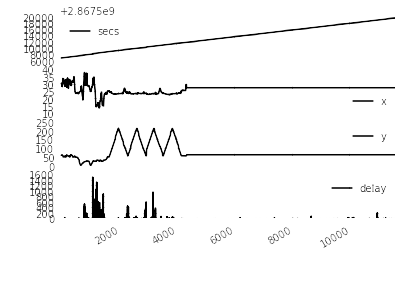

In [217]:
pd.rolling_sum(msgs, 2).plot(subplots=True)
plt.savefig('test.pdf', ls=0.1)

In [215]:
msgs_patrolling = msgs[0:5500]
msgs_docked = msgs[6000:]

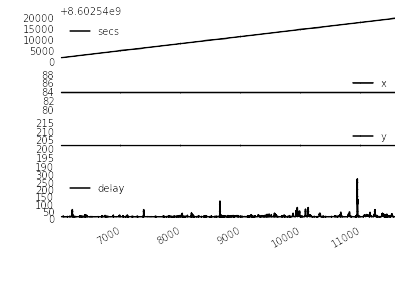

In [216]:
pd.rolling_sum(msgs_docked, 6).plot(subplots=True)
plt.savefig('test_docked.pdf', ls=0.1)

In [131]:
pd.rolling_sum(msgs_patrolling, 6).plot(subplots=True)
# plt.savefig('test_patrolling.pdf', ls=0.1)

array([<matplotlib.axes.AxesSubplot object at 0xdaed46c>,
       <matplotlib.axes.AxesSubplot object at 0xc035acc>], dtype=object)

# Plot Docked

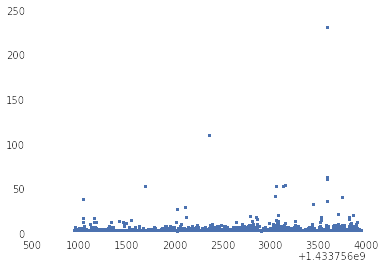

In [222]:
plt.plot(msgs_docked.secs, msgs_docked.delay, '.')

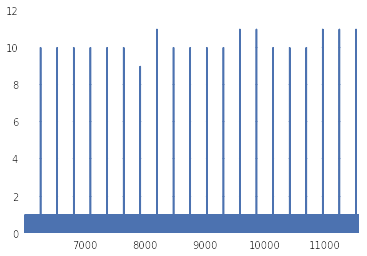

In [214]:
import operator as op
pd.rolling_apply(msgs_docked.secs, 2, np.diff).plot()

# Plot Patrolling

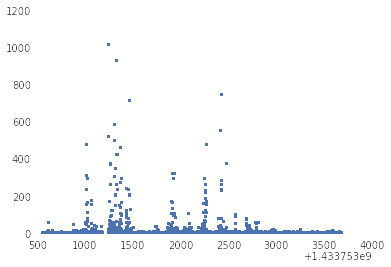

In [213]:
plt.plot(msgs_patrolling.secs, msgs_patrolling.delay, '.')

### Plot Network Losses

Populating the interactive namespace from numpy and matplotlib


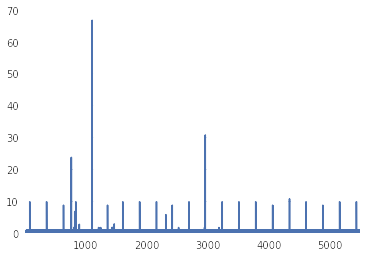

In [212]:
%pylab inline
import operator as op
pd.rolling_apply(msgs_patrolling.secs, 2, np.diff).plot()

# Measuring time between Network Losses

Getting delay between messages when the robot was docked

In [184]:
delays = msgs_docked.secs - msgs_docked.secs.shift()
delays.head()

6001   NaN
6002     1
6003     0
6004     1
6005     0
Name: secs, dtype: float64

As you can see, mean delay is a bit higer than 0.5, which is the rate at which pings were sent

In [186]:
delays.describe()

count    5575.000000
mean        0.538117
std         0.767997
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: secs, dtype: float64

Now we are going to discard normal messages and get only messages received after network losses so we can get the delay between them:

In [188]:
network_losses = pd.Series(delays[delays>1].index)
network_losses.head()

0    6259
1    6535
2    6812
3    7089
4    7367
dtype: int64

In [190]:
network_losses.count()

20

As we can see, we've got 20 network losses in our dataset. Now let's measure how much time passed between them

In [197]:
time_between_losses = pd.rolling_apply(pd.Series(delays[delays>1].index/2), 2, np.diff)
time_between_losses

0     NaN
1     138
2     139
3     138
4     139
5     138
6     138
7     139
8     138
9     139
10    139
11    138
12    137
13    138
14    138
15    138
16    139
17    137
18    138
19    139
dtype: float64

We can see that network losses have been fairly periodical with a mean period of almost **140 seconds**:

In [223]:
time_between_losses.mean()

138.26315789473685

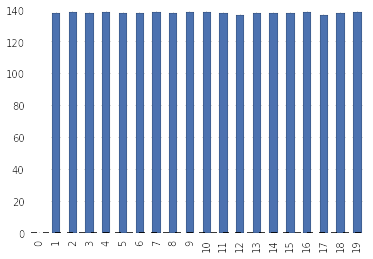

In [224]:
time_between_losses.plot(kind='bar')